In [1]:
import numpy as np
import random
import sympy as sp
import numpy as np
import numpy.linalg as la

%matplotlib notebook
import matplotlib.pyplot as plt
plt.ioff()

plt.rcParams['figure.figsize'] = [10, 5]

In [2]:
wx = sp.symbols('w_1:3')
sx = sp.symbols('s_1:3')
#px = ()
px = sp.symbols('p_1:3')

def getA(s,w,p):
    if not isinstance(w, tuple):
        w = (w,)
    if not isinstance(s, tuple):
        s = (s,)
    if not isinstance(p, tuple):
        p = (p,)
    A = sp.zeros(len(2*w+p), len(2*w)+len(p))
    for i,(v,r) in enumerate(zip(w,s)):
        XX = sp.Matrix([[r, v],[-v,r]])
        ix = 2*i
        A[ix, ix] = r
        A[ix+1, ix+1] = r
        A[ix, ix+1] = v
        A[ix+1, ix] = -v
    for i,r in enumerate(p):
        A[len(2*w)+i, len(2*w)+i] = r
    return A
sp.pprint(getA(wx,sx,px))

def to_sympy_vector(syms):
    return sp.Matrix(syms)
#sp.pprint(to_sympy_vector(wx+sx))

def get_value_by_symbol(values, all_syms, syms):
    res = []
    for sy in syms:
        idx = list(all_syms).index(sy)
        res.append(values[idx])
    return np.matrix(np.array(res).squeeze())

def get_accessor(all_syms_vector, syms):
    return sp.lambdify(all_syms_vector, syms)

assert(np.all(get_value_by_symbol(np.arange(len(sx+wx)), sx+wx, sx) == np.arange(len(sx))))

⎡w₁   s₁   0   0   0   0 ⎤
⎢                        ⎥
⎢-s₁  w₁   0   0   0   0 ⎥
⎢                        ⎥
⎢ 0   0   w₂   s₂  0   0 ⎥
⎢                        ⎥
⎢ 0   0   -s₂  w₂  0   0 ⎥
⎢                        ⎥
⎢ 0   0    0   0   p₁  0 ⎥
⎢                        ⎥
⎣ 0   0    0   0   0   p₂⎦


In [3]:
def getA2(init_arr):
    num_cplx_poles = 0
    num_real_poles = 0
    A = None
    w_init = []
    ws = []
    s_init = []
    ss = []
    p_init = []
    ps = []
    
    for val in init_arr:
        if np.iscomplex(val):
            if np.conjugate(val) in init_arr:
                print "Ignored additional complex conjugate pole: {}".format(np.conjugate(val))
                init_arr.remove(np.conjugate(val))
            num_cplx_poles = num_cplx_poles + 1
            w = sp.symbols('w_{}'.format(num_cplx_poles)) # creates tuple (w_1)
            s = sp.symbols('s_{}'.format(num_cplx_poles)) # creates tuple (s_1)
            X = sp.Matrix([[s, w],[-w,s]])
            s_init.append(val.real)
            ss.append(s)
            w_init.append(val.imag)
            ws.append(w)
        else:
            num_real_poles = num_real_poles + 1
            p = sp.symbols('p_{}'.format(num_real_poles))
            X = sp.Matrix([p])
            p_init.append(val)
            ps.append(p)
        if A is None:
            A = X
        else:
            if not A:
                A = X
            else:
                A = A.row_insert(A.shape[0], sp.zeros(X.shape[0], A.shape[1]))
                A = A.col_insert(A.shape[1], sp.zeros(A.shape[1], X.shape[0]).row_insert(A.shape[0], X))
    return A, (tuple(ss), s_init), (tuple(ws), w_init), (tuple(ps), p_init)

A, (ss, s_init), (ws, w_init), (ps, p_init) = getA2([2+3j, -2])

sp.pprint(A)

print ws, w_init
print ps, p_init

⎡s₁   w₁  0 ⎤
⎢           ⎥
⎢-w₁  s₁  0 ⎥
⎢           ⎥
⎣ 0   0   p₁⎦
(w_1,) [3.0]
(p_1,) [-2]


In [4]:
### Define System model
num_cplx_poles = 1
num_real_poles = 1

# define symbols
#w = sp.symbols('w_1:2') # creates tuple (w_1) 
#s = sp.symbols('s_1:2') # creates tuple (s_1) 
#b = sp.symbols('b_1:3') # creates tuple (b_1, b_2)
#d = sp.symbols('d_1:2') # creates tuple (d_1) 
#x = sp.symbols('x_1:3') # creates tuple (x_1, x_2) 
#c = sp.symbols('c_1:3') #creates tuple (c_1, c_2)
    
if num_cplx_poles == 0:
    w = ()
    s = ()
else:
    w = sp.symbols('w_1:{}'.format(num_cplx_poles+1)) # creates tuple (w_1, w_2)
    s = sp.symbols('s_1:{}'.format(num_cplx_poles+1)) # creates tuple (s_1, s_2)

if num_real_poles == 0:
    p = ()
else:
    p = sp.symbols('p_1:{}'.format(num_real_poles+1)) # creates tuple (s_1, s_2)

b = sp.symbols('b_1:{}'.format(2*num_cplx_poles+num_real_poles+1)) # creates tuple (b_1, b_2, b_3, b_4)
d = sp.symbols('d_1:2') # creates tuple (d_1)
x = sp.symbols('x_1:{}'.format(2*num_cplx_poles+num_real_poles+1)) # creates tuple (x_1, x_2, x_3, x_4)
c = sp.symbols('c_1:{}'.format(2*num_cplx_poles+num_real_poles+1)) # creates tuple (c_1, c_2, c_3, c_4)

u = sp.symbols('u_1:2')

# define structures / matrizes / vectors of symbols
X = to_sympy_vector(x)
U = to_sympy_vector(u)

A = getA(s, w, p)
A, (s, s_init), (w, w_init), (p, p_init) = getA2([2+3j, -2])
B = to_sympy_vector(b)
C = to_sympy_vector(c).T
D = to_sympy_vector(d)

AA = sp.lambdify(s+w+p, A)
BB = sp.lambdify(b, B)
CC = sp.lambdify(c, C)
DD = sp.lambdify(d, D)

z = x+s+w+p+b+c+d
Z = to_sympy_vector(z)

zu = z+u

fx = A*X+B*U

f = sp.Matrix([0 for _ in range(len(z)-len(x))])
f = fx.col_join(f)

print "f="; sp.pprint(f)
ff = sp.lambdify(zu, f)

print "F="; sp.pprint(f.jacobian(z))
FF = sp.lambdify(zu, f.jacobian(z))

h = C*X+D*U
print "h="; sp.pprint(h)
hh = sp.lambdify(zu, h)

print "H="; sp.pprint(h.jacobian(z))
HH = sp.lambdify(zu, h.jacobian(z))


f=
⎡b₁⋅u₁ + s₁⋅x₁ + w₁⋅x₂⎤
⎢                     ⎥
⎢b₂⋅u₁ + s₁⋅x₂ - w₁⋅x₁⎥
⎢                     ⎥
⎢    b₃⋅u₁ + p₁⋅x₃    ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎣          0          ⎦
F=
⎡s₁   w₁  0   x₁  x₂   0   u₁  0   0   0  0  0  0⎤
⎢                                                ⎥
⎢-w₁  s₁  0   x₂  -x₁  0   0   u₁  0   0  0  0  0⎥
⎢                                                ⎥
⎢ 0   0   p₁  0    0   x₃  0   0   u₁  0  0  0  0⎥
⎢                                                ⎥
⎢ 0   0   0   0    0   0   0   0   0   0  0  0  0⎥
⎢                                    

In [5]:
# Unroll for np.matrix instead of np.array
def _c(M):
    sh = M.shape
    if sh[0] == 1:
        return M.tolist()[0]
    elif sh[1] == 1:
        return M.T.tolist()[0]
    else:
        print "WARNING! Unrolling can go horribly wrong with matrizes!"
        return M.ravel().tolist[0]
        
zu_array = np.random.rand(len(zu))
#print ff(*zu_array)

zu_matrix = np.matrix(zu_array)
#print ff(*_c(zu_matrix))

assert(np.all(ff(*zu_array) == ff(*_c(zu_matrix))))

In [6]:
rho = 0.1

#R = np.eye(len(z))
R = 1
print "R:", R

q = np.array([])
for sym in z:
    if sym in X.T.row_join(C):
        q = np.hstack((q, 0))
    else:
        q = np.hstack((q, 1))

Q = rho * np.matrix(np.diag(q))
print "Q:\n", Q

R: 1
Q:
[[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.1 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.1 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.1 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.1 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.1 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1]]


<IPython.core.display.Javascript object>


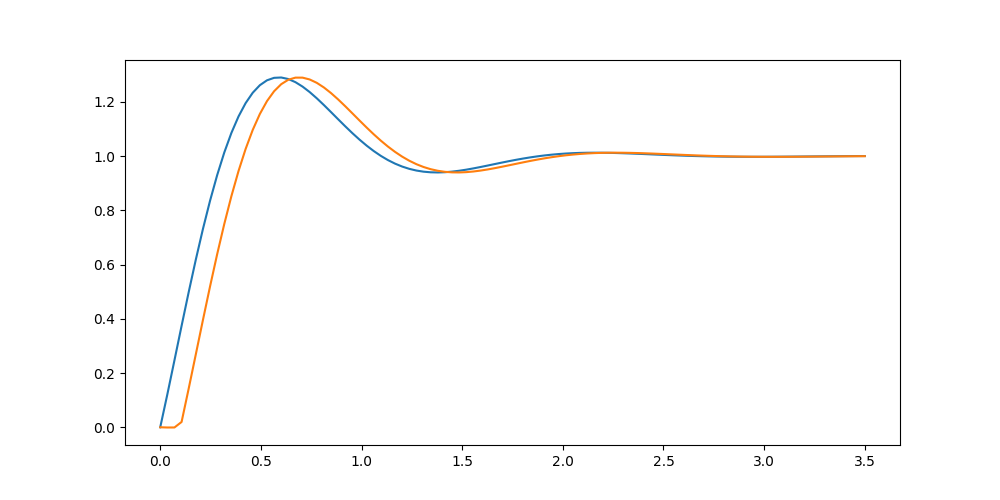

1.0
[-2.+4.j -2.-4.j]


In [7]:
import control as con

Af = np.matrix([[  -2, 4],
                [  -4, -2]])

Bf = np.matrix([[ 1],
                [ 1]])

Cf = np.matrix([[ 1/0.3, 0.]])

Df = np.matrix([[ 0.]])

Tf = 0.1

ss2 = con.ss(Af, Bf, Cf, Df)
plt.plot(*con.step_response(ss2))
#plt.show()


numerator, denominator = con.pade(Tf, 15)

tf3 = con.series(ss2, con.tf(numerator,denominator))
ss3 = con.tf2ss(tf3)

plt.plot(*con.step_response(ss3))
plt.show()

Af = ss3.A
Bf = ss3.B
Cf = ss3.C
Df = ss3.D

print con.dcgain(ss2)
print ss2.pole()


In [8]:
### Testsystem ####
xx_0 = np.zeros((len(Bf),1))
u_k000 = np.matrix([0.1])

#print Af.dot(xx_0)
#print Bf.dot(u_k000)

x_t_real = None
def calc_TestSystem(u):
    global Af, Bf, Cf, Df, x_t_real

    #print "u:", u
    if x_t_real is None:
        #print "x_t neu zero"
        x_t_real = xx_0

    #print "Af:\n", Af
    #print "x_t:\n", x_t_real
    x_dot = Af.dot(x_t_real)
    x_dot = x_dot + Bf.dot(u)
    y = Cf.dot(x_t_real) + Df.dot(u)
    
    #print x_dot
    x_t_real = x_t_real + x_dot*T

    return y

In [9]:
# return real part of a vector
def real_vector(vector):
    return map(lambda x: x.real, vector)

# return imaginary part of a vector
def imag_vector(vector):
    return map(lambda x: x.imag, vector)

In [10]:
# initial
random.seed(42) # Set the random number generator to a fixed sequence.

# A
#s_k0 = np.matrix([-2])#, -2.1]) # real Teil
#s_k0 = np.matrix(-1*(1.0+np.random.rand(len(s))))#, -2.1]) # real Teil
s_k0 = np.matrix(s_init)
#print s_k0

#w_k0 = np.matrix([-2.2])#, -2.3])  # (+/-) imag Teil
#w_k0 = np.matrix((1.0+np.random.rand(len(w))))#, -2.1]) # imag Teil
w_k0 = np.matrix(w_init)
#print w_k0

#p_k0 = np.matrix((-1.0+np.random.rand(len(p)))) # rein real Teil
p_k0 = np.matrix(p_init)
#print p_k0

#b_k0 = np.matrix([3.1, 3.2])#, 3.3, 3.4])
b_k0 = np.matrix((np.random.rand(len(b))))#, -2.1]) # real Teil

#c_k0 = np.matrix([4.1, 4.2])#, 4.3, 4.4])
c_k0 = np.matrix((np.random.rand(len(c))))#, -2.1]) # real Teil

d_k0 = np.matrix(np.zeros(len(d)))

P_k0 = np.eye(len(z))

x_k0 = np.matrix(np.zeros(len(x))).T#, 0, 0]).T

u_k0 = np.matrix([0.1])

T = 0.001


# First values
x_k = x_k0
x_t = np.matrix([0, 0]).T
u_k = u_k0
z_k = np.hstack((x_k0.T, s_k0, w_k0, p_k0, b_k0, c_k0, d_k0)).T
#print "z_k:", z_k

P_k = P_k0

# naive Logging 
poles = []
y = []
y_e = []

u = []
nor0 = []
nor1 = []
nor2 = []
nor3 = []
nor4 = []

# Create accessors
x_from_z = get_accessor(Z, x)
s_from_z = get_accessor(Z, s)
w_from_z = get_accessor(Z, w)
p_from_z = get_accessor(Z, p)

swp_from_z = get_accessor(Z, s+w+p)

b_from_z = get_accessor(Z, b)
c_from_z = get_accessor(Z, c)
d_from_z = get_accessor(Z, d)

# Loop start
#step_time = np.random.randint(low=10, high=200)*T
step_time = 0.1
for cnt, t in enumerate(np.arange(T, 2000, T)):

    # Every two seconds new step
    if np.isclose(t, step_time, T):
        u_k = u_k0 + random.uniform(-1, 1)
        step = np.random.randint(low=0, high=3000)*T
        step_time = step + t
        #step_time = np.random.randint(100)*T + 0.1
        print "step @ {} for {}: u={}".format(t, step, u_k)
        s_k = np.matrix(s_from_z(*_c(z_k))).T
        w_k = np.matrix(w_from_z(*_c(z_k))).T
        p_k = np.matrix(p_from_z(*_c(z_k))).T
        poles.append(np.array([complex(si,wi) for si,wi in zip(s_k, w_k)] +
                              [complex(si,-wi) for si,wi in zip(s_k, w_k)] +
                              [pi for pi in p_k]))
        
    y_t = calc_TestSystem(u_k)
    #print "x_k:\n",x_k
        
    y.append(y_t[0,0])
    u.append(u_k[0,0])
    
    ##### Reconstruction from z
    x_k = np.matrix(x_from_z(*_c(z_k))).T
    
    swp_k = np.matrix(swp_from_z(*_c(z_k)))

    b_k = np.matrix(b_from_z(*_c(z_k)))
    c_k = np.matrix(c_from_z(*_c(z_k)))
    d_k = np.matrix(d_from_z(*_c(z_k)))

    
    ## System
    A_k = AA(*_c(swp_k))
    B_k = BB(*_c(b_k))
    C_k = CC(*_c(c_k))
    D_k = DD(*_c(d_k))


    ##### Evaluation
    # State space
    dx_k = A_k.squeeze().dot(x_k) + B_k.dot(u_k)
    y_k = C_k.dot(x_k) + D_k.dot(u_k)
    y_e.append(y_k[0,0])

    # Concate values for lambdafied Jacobians
    zu_k = np.hstack((z_k.T, u_k))
    #print "zu_k:\n", zu_k
    
    h_k = np.matrix(hh(*_c(zu_k))) # h = y_k (predicted)
    #print "h_k:\n", h_k
    H_k = np.matrix(HH(*_c(zu_k))) # h.Jacobian
    #print "H_k:\n", H_k

    
    f_k = np.matrix(ff(*_c(zu_k))) # f
    #print "f_k:\n", f_k
    F_k = np.matrix(FF(*_c(zu_k))) #f.Jacobian
    #print "F_k:\n", F_k
    
    ##### Kalman Filter

    # Prediction
    K_k = P_k.dot(H_k.T).dot(la.inv(H_k.dot(P_k).dot(H_k.T) + R))
    #print "K_k:\n", K_k

    Ps_k = (np.eye(len(z)) - K_k.dot(H_k)).dot(P_k) # P*_k
    #print "Ps_k:\n", Ps_k

    # Correction
    P_k1 = Ps_k + T*(F_k.dot(Ps_k) + Ps_k.dot(F_k.T) + Q)
    #print "P_k1:\n", P_k1

    z_k1 = (z_k + T*f_k + K_k.dot((y_t - h_k)))
    #print "z_k1:", z_k1

    # State Propagation
    z_k = np.matrix(z_k1)
    #print "z_k:\n", z_k
    
    P_k = np.matrix(P_k1).astype(np.float)
    #print "P_k:\n", P_k

    nor0.append(np.trace(P_k))
    nor1.append(la.norm(P_k, 'fro'))
    nor2.append(la.norm(P_k, np.inf))
    nor3.append(la.norm(P_k, 1))
    nor4.append(la.norm(P_k, 2))

step @ 0.1 for 2.214: u=[[0.3788536]]
step @ 2.312 for 2.116: u=[[-0.84997849]]
step @ 4.424 for 0.719: u=[[-0.34994136]]
step @ 5.138 for 0.107: u=[[-0.45357852]]
step @ 5.24 for 2.333: u=[[0.57294243]]
step @ 7.566 for 1.938: u=[[0.45339897]]
step @ 9.495 for 0.24: u=[[0.88435914]]
step @ 9.726 for 0.127: u=[[-0.72612233]]
step @ 9.844 for 0.677: u=[[-0.05615636]]
step @ 10.511 for 0.982: u=[[-0.84040556]]
step @ 11.482 for 2.831: u=[[-0.46272405]]
step @ 14.299 for 1.313: u=[[0.11071058]]
step @ 15.597 for 2.072: u=[[-0.84692806]]
step @ 17.652 for 2.824: u=[[-0.5023247]]
step @ 20.456 for 1.176: u=[[0.39976888]]
step @ 21.611 for 0.837: u=[[0.18988296]]
step @ 22.426 for 1.644: u=[[-0.45911876]]
step @ 24.046 for 1.03: u=[[0.27853137]]
step @ 25.051 for 2.805: u=[[0.71886091]]
step @ 27.829 for 0.44: u=[[-0.88700248]]
step @ 28.241 for 2.655: u=[[0.7116385]]
step @ 30.866 for 1.67: u=[[0.49627879]]
step @ 32.504 for 2.839: u=[[-0.21949897]]
step @ 35.308 for 1.065: u=[[-0.589041]]


step @ 263.283 for 2.711: u=[[0.9465312]]
step @ 265.729 for 1.041: u=[[-0.01373851]]
step @ 266.504 for 0.464: u=[[0.82269821]]
step @ 266.702 for 0.603: u=[[0.20065062]]
step @ 267.038 for 2.033: u=[[-0.79882334]]
step @ 268.802 for 1.631: u=[[1.09856494]]
step @ 270.163 for 0.824: u=[[0.77205517]]
step @ 270.717 for 1.786: u=[[1.03799251]]
step @ 272.231 for 1.596: u=[[0.95273397]]
step @ 273.554 for 0.01: u=[[0.79739147]]
step @ 273.555 for 2.354: u=[[-0.56737778]]
step @ 275.634 for 0.66: u=[[0.07128225]]
step @ 276.018 for 1.192: u=[[-0.4725054]]
step @ 276.933 for 2.285: u=[[-0.09791941]]
step @ 278.939 for 2.337: u=[[-0.7827292]]
step @ 280.995 for 1.621: u=[[-0.14205376]]
step @ 282.334 for 1.749: u=[[1.07061769]]
step @ 283.799 for 0.542: u=[[-0.36959388]]
step @ 284.057 for 2.79: u=[[0.6681412]]
step @ 286.561 for 0.638: u=[[0.01001673]]
step @ 286.912 for 1.747: u=[[-0.05398503]]
step @ 288.371 for 1.85: u=[[1.01463528]]
step @ 289.931 for 0.058: u=[[1.09084538]]
step @ 289

step @ 474.99 for 2.046: u=[[-0.6454244]]
step @ 476.559 for 0.732: u=[[-0.05910733]]
step @ 476.814 for 1.04: u=[[0.98072734]]
step @ 477.377 for 2.029: u=[[0.45463589]]
step @ 478.927 for 1.913: u=[[0.90561109]]
step @ 480.36 for 2.477: u=[[0.33102983]]
step @ 482.355 for 1.93: u=[[-0.29810025]]
step @ 483.801 for 2.032: u=[[0.19587443]]
step @ 485.348 for 2.482: u=[[-0.89918812]]
step @ 487.343 for 2.222: u=[[-0.32617257]]
step @ 489.076 for 0.759: u=[[-0.0402237]]
step @ 489.346 for 1.789: u=[[0.25996956]]
step @ 490.644 for 0.702: u=[[0.40941125]]
step @ 490.855 for 2.008: u=[[0.02997638]]
step @ 492.371 for 0.855: u=[[-0.0156804]]
step @ 492.733 for 1.564: u=[[-0.4725972]]
step @ 493.803 for 2.387: u=[[0.04637237]]
step @ 495.694 for 2.15: u=[[0.90236165]]
step @ 497.347 for 2.764: u=[[0.69204952]]
step @ 499.611 for 2.719: u=[[-0.56061721]]
step @ 501.828 for 0.055: u=[[-0.73040893]]
step @ 501.829 for 1.57: u=[[0.13090402]]
step @ 502.896 for 0.978: u=[[0.36588171]]
step @ 503.

step @ 658.783 for 2.599: u=[[0.56205243]]
step @ 660.721 for 2.882: u=[[-0.36320892]]
step @ 662.94 for 0.205: u=[[0.80342632]]
step @ 662.941 for 2.873: u=[[0.76146204]]
step @ 665.149 for 2.253: u=[[-0.7266742]]
step @ 666.735 for 2.451: u=[[0.86326237]]
step @ 668.517 for 2.313: u=[[-0.41227312]]
step @ 670.16 for 2.401: u=[[0.02941693]]
step @ 671.889 for 0.815: u=[[0.32066341]]
step @ 672.032 for 2.47: u=[[-0.14202139]]
step @ 673.828 for 0.736: u=[[-0.8426]]
step @ 673.89 for 2.693: u=[[0.80190567]]
step @ 675.907 for 2.393: u=[[-0.53632029]]
step @ 677.622 for 1.782: u=[[-0.4757603]]
step @ 678.725 for 1.052: u=[[0.69566471]]
step @ 679.098 for 2.503: u=[[-0.21932231]]
step @ 680.92 for 1.976: u=[[0.86063996]]
step @ 682.214 for 0.451: u=[[0.5023675]]
step @ 682.215 for 2.861: u=[[-0.34746285]]
step @ 684.391 for 2.326: u=[[-0.87969777]]
step @ 686.031 for 2.267: u=[[0.99612516]]
step @ 687.61 for 0.995: u=[[-0.72877408]]
step @ 687.917 for 2.694: u=[[0.54014933]]
step @ 689.92

step @ 830.952 for 2.559: u=[[-0.58324367]]
step @ 832.678 for 2.303: u=[[0.20167801]]
step @ 834.147 for 1.485: u=[[0.20450282]]
step @ 834.797 for 2.058: u=[[-0.7135816]]
step @ 836.019 for 0.837: u=[[1.08451428]]
step @ 836.02 for 1.657: u=[[0.92585976]]
step @ 836.84 for 2.279: u=[[0.02289579]]
step @ 838.28 for 2.092: u=[[-0.6650677]]
step @ 839.532 for 2.33: u=[[0.76428635]]
step @ 841.021 for 0.764: u=[[0.09675101]]
step @ 841.022 for 0.969: u=[[0.53320665]]
step @ 841.15 for 1.137: u=[[0.11774403]]
step @ 841.445 for 1.014: u=[[-0.35315021]]
step @ 841.617 for 2.019: u=[[0.76944789]]
step @ 842.793 for 2.326: u=[[1.06048927]]
step @ 844.274 for 1.289: u=[[-0.41253819]]
step @ 844.718 for 1.471: u=[[0.20253015]]
step @ 845.343 for 1.167: u=[[-0.13282797]]
step @ 845.664 for 2.471: u=[[0.9437363]]
step @ 847.287 for 0.235: u=[[0.11648178]]
step @ 847.288 for 2.719: u=[[0.85865251]]
step @ 849.157 for 0.269: u=[[0.82805387]]
step @ 849.158 for 1.718: u=[[-0.34750519]]
step @ 850.0

step @ 971.576 for 0.366: u=[[-0.4323562]]
step @ 971.577 for 1.169: u=[[-0.8499507]]
step @ 971.774 for 0.028: u=[[0.86846969]]
step @ 971.775 for 0.365: u=[[0.22281476]]
step @ 971.776 for 1.947: u=[[0.93051182]]
step @ 972.75 for 0.544: u=[[-0.4572656]]
step @ 972.751 for 0.22: u=[[-0.77356592]]
step @ 972.752 for 2.071: u=[[0.7477107]]
step @ 973.849 for 0.114: u=[[0.91877528]]
step @ 973.85 for 2.893: u=[[-0.29561965]]
step @ 975.767 for 2.47: u=[[-0.08340829]]
step @ 977.259 for 1.18: u=[[-0.62044597]]
step @ 977.461 for 1.101: u=[[0.99252307]]
step @ 977.584 for 0.405: u=[[-0.29127083]]
step @ 977.585 for 0.44: u=[[0.08524924]]
step @ 977.586 for 2.15: u=[[-0.705616]]
step @ 978.757 for 2.223: u=[[0.87451862]]
step @ 980.0 for 0.091: u=[[-0.6286719]]
step @ 980.001 for 1.073: u=[[0.00728751]]
step @ 980.093 for 2.736: u=[[0.44097244]]
step @ 981.847 for 1.092: u=[[0.58628024]]
step @ 981.957 for 0.001: u=[[0.99194817]]
step @ 981.958 for 2.515: u=[[-0.06174649]]
step @ 983.489 f

step @ 1086.331 for 2.055: u=[[0.44793742]]
step @ 1087.298 for 1.772: u=[[-0.35579431]]
step @ 1087.981 for 1.022: u=[[0.42387739]]
step @ 1087.982 for 1.43: u=[[0.07132341]]
step @ 1088.323 for 2.905: u=[[-0.01591163]]
step @ 1090.137 for 2.438: u=[[-0.35366631]]
step @ 1091.483 for 0.919: u=[[0.60988629]]
step @ 1091.484 for 1.421: u=[[-0.67236498]]
step @ 1091.813 for 2.054: u=[[-0.04017273]]
step @ 1092.774 for 0.444: u=[[-0.33350706]]
step @ 1092.775 for 0.148: u=[[0.45697251]]
step @ 1092.776 for 0.581: u=[[0.07326551]]
step @ 1092.777 for 1.804: u=[[0.43426512]]
step @ 1093.487 for 0.101: u=[[-0.80916527]]
step @ 1093.488 for 2.799: u=[[-0.10947321]]
step @ 1095.191 for 0.84: u=[[0.29864991]]
step @ 1095.192 for 1.019: u=[[-0.88462583]]
step @ 1095.193 for 1.803: u=[[-0.29716128]]
step @ 1095.9 for 2.572: u=[[-0.47753204]]
step @ 1097.374 for 2.016: u=[[-0.62553039]]
step @ 1098.291 for 2.306: u=[[-0.38896099]]
step @ 1099.497 for 1.552: u=[[-0.24375529]]
step @ 1099.948 for 1.

step @ 1202.678 for 0.971: u=[[0.59707304]]
step @ 1202.679 for 2.69: u=[[-0.00214407]]
step @ 1204.164 for 2.273: u=[[0.1680223]]
step @ 1205.231 for 0.919: u=[[-0.28106421]]
step @ 1205.232 for 2.748: u=[[0.71724774]]
step @ 1206.773 for 2.233: u=[[0.03803121]]
step @ 1207.797 for 2.394: u=[[0.77022679]]
step @ 1208.981 for 2.959: u=[[-0.16431808]]
step @ 1210.729 for 0.507: u=[[0.99426034]]
step @ 1210.73 for 0.122: u=[[1.06887959]]
step @ 1210.731 for 2.679: u=[[0.02335996]]
step @ 1212.197 for 2.609: u=[[-0.33645653]]
step @ 1213.592 for 1.359: u=[[-0.13625513]]
step @ 1213.737 for 0.166: u=[[0.15491958]]
step @ 1213.738 for 0.704: u=[[1.03253631]]
step @ 1213.739 for 0.74: u=[[0.73378248]]
step @ 1213.74 for 1.085: u=[[0.70251845]]
step @ 1213.741 for 1.071: u=[[-0.62320293]]
step @ 1213.742 for 2.264: u=[[-0.39999358]]
step @ 1214.79 for 2.306: u=[[0.38235807]]
step @ 1215.879 for 2.343: u=[[0.84823389]]
step @ 1217.004 for 0.356: u=[[0.20908149]]
step @ 1217.005 for 0.611: u=[[

step @ 1295.412 for 2.265: u=[[-0.37644665]]
step @ 1296.38 for 0.88: u=[[-0.37942046]]
step @ 1296.381 for 1.627: u=[[-0.00745378]]
step @ 1296.71 for 0.817: u=[[1.09273022]]
step @ 1296.711 for 0.078: u=[[-0.32884624]]
step @ 1296.712 for 2.133: u=[[0.93295782]]
step @ 1297.547 for 2.132: u=[[0.08240039]]
step @ 1298.38 for 0.164: u=[[-0.65472516]]
step @ 1298.381 for 1.327: u=[[0.80565258]]
step @ 1298.409 for 2.286: u=[[0.00408537]]
step @ 1299.395 for 2.928: u=[[0.89735806]]
step @ 1301.021 for 1.584: u=[[-0.00977761]]
step @ 1301.303 for 2.495: u=[[-0.72441852]]
step @ 1302.495 for 1.843: u=[[0.46385852]]
step @ 1303.034 for 1.376: u=[[0.79104244]]
step @ 1303.106 for 2.292: u=[[-0.26082446]]
step @ 1304.093 for 1.85: u=[[-0.20514941]]
step @ 1304.638 for 0.399: u=[[-0.77012184]]
step @ 1304.639 for 2.226: u=[[0.18434272]]
step @ 1305.559 for 1.765: u=[[0.88266336]]
step @ 1306.017 for 2.75: u=[[0.8027241]]
step @ 1307.459 for 0.362: u=[[0.52361821]]
step @ 1307.46 for 0.961: u=[

step @ 1386.267 for 0.58: u=[[-0.30041887]]
step @ 1386.268 for 2.388: u=[[0.73149767]]
step @ 1387.268 for 2.763: u=[[-0.16328438]]
step @ 1388.641 for 1.139: u=[[0.44761278]]
step @ 1388.642 for 2.148: u=[[1.05979606]]
step @ 1389.4 for 0.878: u=[[0.26740428]]
step @ 1389.401 for 2.101: u=[[0.69350963]]
step @ 1390.111 for 0.265: u=[[0.55064843]]
step @ 1390.112 for 0.972: u=[[0.4760873]]
step @ 1390.113 for 0.082: u=[[-0.84670569]]
step @ 1390.114 for 2.393: u=[[0.04918043]]
step @ 1391.115 for 2.891: u=[[1.03414139]]
step @ 1392.612 for 1.471: u=[[0.66580798]]
step @ 1392.689 for 1.316: u=[[0.65232405]]
step @ 1392.69 for 0.51: u=[[0.25526879]]
step @ 1392.691 for 1.839: u=[[0.54280022]]
step @ 1393.136 for 2.132: u=[[0.26704655]]
step @ 1393.873 for 1.606: u=[[-0.55897588]]
step @ 1394.084 for 0.167: u=[[0.35805048]]
step @ 1394.085 for 0.741: u=[[0.33947161]]
step @ 1394.086 for 0.679: u=[[0.78233425]]
step @ 1394.087 for 0.445: u=[[-0.60444858]]
step @ 1394.088 for 2.985: u=[[0.

step @ 1480.078 for 1.759: u=[[-0.73625939]]
step @ 1480.356 for 2.468: u=[[-0.00650405]]
step @ 1481.342 for 2.893: u=[[0.50753225]]
step @ 1482.751 for 2.932: u=[[-0.74379456]]
step @ 1484.198 for 0.588: u=[[0.22833744]]
step @ 1484.199 for 0.768: u=[[-0.7764839]]
step @ 1484.2 for 2.303: u=[[0.1952985]]
step @ 1485.017 for 1.026: u=[[0.11097411]]
step @ 1485.018 for 2.124: u=[[0.24540335]]
step @ 1485.655 for 2.692: u=[[-0.60029524]]
step @ 1486.859 for 0.632: u=[[-0.24376472]]
step @ 1486.86 for 2.214: u=[[0.14068308]]
step @ 1487.585 for 2.135: u=[[-0.66751996]]
step @ 1488.231 for 2.751: u=[[-0.48919703]]
step @ 1489.492 for 1.042: u=[[0.26629536]]
step @ 1489.493 for 2.38: u=[[-0.71811671]]
step @ 1490.382 for 1.782: u=[[0.12075071]]
step @ 1490.672 for 1.588: u=[[0.71738417]]
step @ 1490.768 for 0.785: u=[[0.0068646]]
step @ 1490.769 for 1.643: u=[[0.12649569]]
step @ 1490.92 for 2.305: u=[[0.01359695]]
step @ 1491.732 for 1.029: u=[[-0.78452644]]
step @ 1491.733 for 1.561: u=[

step @ 1547.232 for 2.495: u=[[0.38338891]]
step @ 1548.178 for 1.452: u=[[0.08119117]]
step @ 1548.179 for 2.26: u=[[-0.56353271]]
step @ 1548.889 for 1.883: u=[[0.68995103]]
step @ 1549.222 for 1.395: u=[[-0.56146858]]
step @ 1549.223 for 1.19: u=[[0.54062706]]
step @ 1549.224 for 1.944: u=[[0.07663264]]
step @ 1549.617 for 2.447: u=[[0.93379878]]
step @ 1550.512 for 1.198: u=[[0.18427371]]
step @ 1550.513 for 2.67: u=[[0.38361893]]
step @ 1551.63 for 1.442: u=[[-0.7825359]]
step @ 1551.631 for 2.379: u=[[-0.83235249]]
step @ 1552.456 for 1.527: u=[[0.79339477]]
step @ 1552.457 for 0.817: u=[[0.99037622]]
step @ 1552.458 for 0.326: u=[[0.43643109]]
step @ 1552.459 for 2.978: u=[[0.62867769]]
step @ 1553.882 for 2.547: u=[[-0.07521556]]
step @ 1554.873 for 2.52: u=[[0.78508943]]
step @ 1555.836 for 2.0: u=[[-0.43713322]]
step @ 1556.279 for 1.22: u=[[0.51433913]]
step @ 1556.28 for 0.61: u=[[-0.88171708]]
step @ 1556.281 for 0.195: u=[[0.11146584]]
step @ 1556.282 for 1.098: u=[[-0.15

step @ 1606.581 for 0.796: u=[[-0.11412974]]
step @ 1606.582 for 2.905: u=[[-0.67222435]]
step @ 1607.878 for 2.632: u=[[0.22770102]]
step @ 1608.9 for 1.356: u=[[0.28445407]]
step @ 1608.901 for 0.491: u=[[0.19125817]]
step @ 1608.902 for 2.154: u=[[0.46342527]]
step @ 1609.445 for 1.151: u=[[0.20019831]]
step @ 1609.446 for 2.826: u=[[1.00600922]]
step @ 1610.66 for 1.948: u=[[0.02324445]]
step @ 1610.996 for 0.035: u=[[0.5167341]]
step @ 1610.997 for 2.016: u=[[-0.02309009]]
step @ 1611.4 for 1.842: u=[[-0.31733758]]
step @ 1611.629 for 1.637: u=[[0.48567056]]
step @ 1611.653 for 1.165: u=[[0.73793114]]
step @ 1611.654 for 1.877: u=[[0.69131367]]
step @ 1611.918 for 0.492: u=[[-0.08171682]]
step @ 1611.919 for 1.635: u=[[0.09860643]]
step @ 1611.941 for 2.903: u=[[0.36667208]]
step @ 1613.23 for 1.548: u=[[-0.41595766]]
step @ 1613.231 for 0.315: u=[[0.41732594]]
step @ 1613.232 for 2.536: u=[[0.53047278]]
step @ 1614.153 for 1.482: u=[[0.67815353]]
step @ 1614.154 for 0.412: u=[[-0

step @ 1655.261 for 1.809: u=[[0.72140543]]
step @ 1655.413 for 1.041: u=[[0.27584779]]
step @ 1655.414 for 1.546: u=[[-0.19873832]]
step @ 1655.415 for 2.001: u=[[0.52150792]]
step @ 1655.759 for 2.33: u=[[0.36554126]]
step @ 1656.431 for 1.495: u=[[-0.56803676]]
step @ 1656.432 for 0.656: u=[[-0.62153007]]
step @ 1656.433 for 1.869: u=[[-0.48676069]]
step @ 1656.644 for 0.207: u=[[-0.48611456]]
step @ 1656.645 for 0.212: u=[[-0.78128433]]
step @ 1656.646 for 2.963: u=[[-0.19836904]]
step @ 1657.95 for 0.512: u=[[-0.33782996]]
step @ 1657.951 for 2.807: u=[[0.17753709]]
step @ 1659.098 for 2.387: u=[[-0.25269277]]
step @ 1659.824 for 2.818: u=[[0.50810752]]
step @ 1660.98 for 1.967: u=[[-0.32133351]]
step @ 1661.285 for 0.406: u=[[-0.36531387]]
step @ 1661.286 for 2.638: u=[[0.81603369]]
step @ 1662.261 for 1.712: u=[[1.0709766]]
step @ 1662.31 for 2.191: u=[[0.45859863]]
step @ 1662.837 for 2.086: u=[[-0.70954967]]
step @ 1663.259 for 2.312: u=[[1.02554399]]
step @ 1663.906 for 2.665

step @ 1714.298 for 2.295: u=[[0.71612016]]
step @ 1714.877 for 0.711: u=[[0.17278035]]
step @ 1714.878 for 1.401: u=[[-0.11853699]]
step @ 1714.879 for 0.473: u=[[0.36858849]]
step @ 1714.88 for 1.823: u=[[0.76905294]]
step @ 1714.987 for 0.133: u=[[0.46211137]]
step @ 1714.988 for 2.47: u=[[-0.76776983]]
step @ 1715.741 for 0.894: u=[[0.49735176]]
step @ 1715.742 for 2.174: u=[[0.55991675]]
step @ 1716.199 for 2.938: u=[[0.79293623]]
step @ 1717.418 for 1.999: u=[[-0.78418811]]
step @ 1717.698 for 2.341: u=[[-0.7275744]]
step @ 1718.319 for 0.01: u=[[-0.03103282]]
step @ 1718.32 for 1.241: u=[[0.00674368]]
step @ 1718.321 for 0.563: u=[[0.31766481]]
step @ 1718.322 for 1.13: u=[[-0.28141987]]
step @ 1718.323 for 1.615: u=[[0.58338702]]
step @ 1718.324 for 0.293: u=[[0.58131636]]
step @ 1718.325 for 2.897: u=[[-0.66111399]]
step @ 1719.501 for 0.516: u=[[0.51580121]]
step @ 1719.502 for 2.317: u=[[0.50299922]]
step @ 1720.098 for 2.293: u=[[-0.57233474]]
step @ 1720.669 for 0.114: u=[

step @ 1766.234 for 2.8: u=[[-0.23690022]]
step @ 1767.265 for 0.451: u=[[-0.81460736]]
step @ 1767.266 for 1.654: u=[[0.02198984]]
step @ 1767.267 for 1.074: u=[[-0.56402158]]
step @ 1767.268 for 2.204: u=[[0.2477684]]
step @ 1767.703 for 0.714: u=[[0.7433708]]
step @ 1767.704 for 0.098: u=[[-0.11000262]]
step @ 1767.705 for 1.683: u=[[-0.84103541]]
step @ 1767.706 for 0.106: u=[[0.46642583]]
step @ 1767.707 for 2.742: u=[[-0.55438558]]
step @ 1768.679 for 1.012: u=[[-0.47056779]]
step @ 1768.68 for 2.602: u=[[-0.52569777]]
step @ 1769.511 for 0.024: u=[[-0.34029089]]
step @ 1769.512 for 2.114: u=[[0.8668476]]
step @ 1769.855 for 0.567: u=[[-0.83070111]]
step @ 1769.856 for 0.186: u=[[0.3383531]]
step @ 1769.857 for 2.379: u=[[-0.40843044]]
step @ 1770.464 for 0.327: u=[[-0.30978967]]
step @ 1770.465 for 0.66: u=[[-0.07601559]]
step @ 1770.466 for 0.736: u=[[0.20137733]]
step @ 1770.467 for 1.145: u=[[-0.77804186]]
step @ 1770.468 for 0.686: u=[[-0.34044803]]
step @ 1770.469 for 0.163

step @ 1810.719 for 1.009: u=[[0.55994801]]
step @ 1810.72 for 2.471: u=[[-0.36947046]]
step @ 1811.378 for 2.448: u=[[-0.33695385]]
step @ 1812.013 for 1.89: u=[[-0.42490343]]
step @ 1812.09 for 2.356: u=[[-0.80072911]]
step @ 1812.632 for 0.74: u=[[0.24353962]]
step @ 1812.633 for 2.459: u=[[0.77970901]]
step @ 1813.277 for 2.63: u=[[-0.59282013]]
step @ 1814.092 for 1.227: u=[[-0.17834216]]
step @ 1814.093 for 0.321: u=[[-0.04478809]]
step @ 1814.094 for 1.237: u=[[-0.3109011]]
step @ 1814.095 for 2.37: u=[[0.42404045]]
step @ 1814.649 for 1.358: u=[[0.30043106]]
step @ 1814.65 for 0.212: u=[[-0.5006504]]
step @ 1814.651 for 1.178: u=[[-0.84852861]]
step @ 1814.652 for 1.15: u=[[-0.55833562]]
step @ 1814.653 for 2.734: u=[[-0.31637707]]
step @ 1815.57 for 0.977: u=[[-0.73612781]]
step @ 1815.571 for 2.096: u=[[0.78753815]]
step @ 1815.85 for 1.166: u=[[-0.2832932]]
step @ 1815.851 for 1.83: u=[[-0.1050653]]
step @ 1815.864 for 0.026: u=[[0.07819362]]
step @ 1815.865 for 1.915: u=[[0

step @ 1857.46 for 1.486: u=[[0.38548062]]
step @ 1857.461 for 2.193: u=[[-0.0523864]]
step @ 1857.795 for 2.957: u=[[-0.1470491]]
step @ 1858.892 for 2.389: u=[[-0.2025816]]
step @ 1859.42 for 0.721: u=[[-0.39600258]]
step @ 1859.421 for 0.492: u=[[0.03339603]]
step @ 1859.422 for 1.551: u=[[0.45439231]]
step @ 1859.423 for 0.226: u=[[0.74862164]]
step @ 1859.424 for 1.843: u=[[-0.10569492]]
step @ 1859.425 for 1.677: u=[[-0.69537579]]
step @ 1859.426 for 2.909: u=[[0.12302743]]
step @ 1860.473 for 1.246: u=[[0.42471091]]
step @ 1860.474 for 0.616: u=[[0.7865679]]
step @ 1860.475 for 2.392: u=[[-0.15154047]]
step @ 1861.005 for 2.41: u=[[0.39468424]]
step @ 1861.552 for 0.771: u=[[0.31810021]]
step @ 1861.553 for 2.489: u=[[-0.30304815]]
step @ 1862.178 for 1.481: u=[[-0.68379094]]
step @ 1862.179 for 1.134: u=[[-0.77232589]]
step @ 1862.18 for 1.425: u=[[1.07672193]]
step @ 1862.181 for 2.612: u=[[0.38118949]]
step @ 1862.929 for 1.06: u=[[0.8229832]]
step @ 1862.93 for 2.993: u=[[-0

step @ 1898.759 for 2.021: u=[[0.96624869]]
step @ 1898.88 for 2.299: u=[[-0.23879277]]
step @ 1899.278 for 2.204: u=[[-0.894524]]
step @ 1899.581 for 2.436: u=[[0.44326626]]
step @ 1900.115 for 1.173: u=[[0.91376009]]
step @ 1900.116 for 1.217: u=[[0.77046433]]
step @ 1900.117 for 0.464: u=[[0.43804386]]
step @ 1900.118 for 0.956: u=[[-0.60171101]]
step @ 1900.119 for 2.033: u=[[-0.71983465]]
step @ 1900.25 for 2.683: u=[[0.12341069]]
step @ 1901.031 for 0.469: u=[[0.54712723]]
step @ 1901.032 for 1.705: u=[[-0.69741904]]
step @ 1901.033 for 0.625: u=[[-0.38821579]]
step @ 1901.034 for 0.665: u=[[-0.43767943]]
step @ 1901.035 for 1.075: u=[[1.07733186]]
step @ 1901.036 for 1.017: u=[[-0.30795564]]
step @ 1901.037 for 0.417: u=[[0.02855471]]
step @ 1901.038 for 2.749: u=[[-0.70038217]]
step @ 1901.884 for 2.948: u=[[-0.55059638]]
step @ 1902.928 for 2.68: u=[[-0.82111096]]
step @ 1903.703 for 2.019: u=[[-0.31886565]]
step @ 1903.817 for 0.673: u=[[0.70319221]]
step @ 1903.818 for 1.927

step @ 1932.338 for 2.617: u=[[0.50002857]]
step @ 1933.021 for 2.937: u=[[0.59685373]]
step @ 1934.023 for 2.126: u=[[-0.30217373]]
step @ 1934.213 for 2.806: u=[[0.50298862]]
step @ 1935.082 for 2.226: u=[[0.82141509]]
step @ 1935.371 for 0.628: u=[[0.52374871]]
step @ 1935.372 for 0.98: u=[[0.97102415]]
step @ 1935.373 for 2.435: u=[[0.36516657]]
step @ 1935.871 for 0.888: u=[[-0.49822184]]
step @ 1935.872 for 1.745: u=[[0.34833518]]
step @ 1935.873 for 2.61: u=[[-0.31884101]]
step @ 1936.545 for 2.375: u=[[-0.20941284]]
step @ 1936.982 for 0.587: u=[[0.44474743]]
step @ 1936.983 for 1.423: u=[[1.06267099]]
step @ 1936.984 for 1.802: u=[[0.40017278]]
step @ 1936.985 for 1.898: u=[[1.01665291]]
step @ 1936.986 for 1.828: u=[[0.10778688]]
step @ 1936.987 for 2.192: u=[[0.48862395]]
step @ 1937.24 for 1.381: u=[[-0.25523721]]
step @ 1937.241 for 0.851: u=[[-0.6691895]]
step @ 1937.242 for 1.501: u=[[-0.1955244]]
step @ 1937.243 for 0.151: u=[[0.06073984]]
step @ 1937.244 for 0.548: u=[

step @ 1967.541 for 2.967: u=[[0.42144633]]
step @ 1968.538 for 1.842: u=[[0.04797535]]
step @ 1968.539 for 2.352: u=[[0.16693553]]
step @ 1968.921 for 1.321: u=[[-0.62723708]]
step @ 1968.922 for 0.42: u=[[-0.11801487]]
step @ 1968.923 for 2.231: u=[[0.69496923]]
step @ 1969.183 for 2.666: u=[[0.19144894]]
step @ 1969.878 for 2.627: u=[[1.02026853]]
step @ 1970.533 for 0.279: u=[[-0.61184893]]
step @ 1970.534 for 1.41: u=[[0.45457809]]
step @ 1970.535 for 0.85: u=[[0.92833783]]
step @ 1970.536 for 0.654: u=[[0.69003424]]
step @ 1970.537 for 0.988: u=[[0.55864915]]
step @ 1970.538 for 2.615: u=[[-0.15373897]]
step @ 1971.18 for 2.11: u=[[0.99893021]]
step @ 1971.317 for 2.413: u=[[0.20704838]]
step @ 1971.757 for 0.003: u=[[0.21013949]]
step @ 1971.758 for 1.369: u=[[-0.65352968]]
step @ 1971.759 for 0.828: u=[[-0.88994032]]
step @ 1971.76 for 1.4: u=[[0.29330977]]
step @ 1971.761 for 0.19: u=[[0.1743041]]
step @ 1971.762 for 1.77: u=[[0.99395878]]
step @ 1971.763 for 1.255: u=[[-0.290

<IPython.core.display.Javascript object>


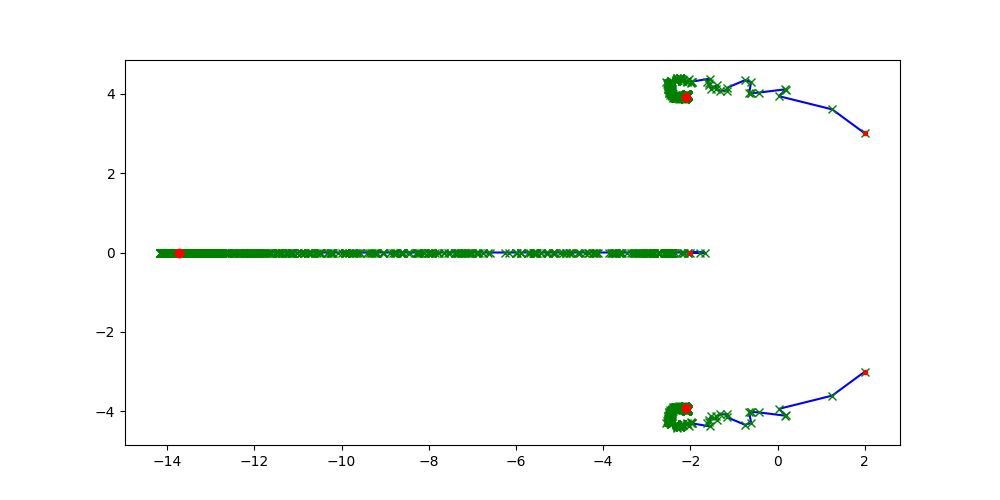

In [11]:
# another approach to plot
real_part = real_vector(poles)
imag_part = imag_vector(poles)

# Display a window with a plot of real, imag
plt.plot(real_part, imag_part, 'b-')
plt.plot(real_vector(poles), imag_vector(poles), 'gx')
plt.plot(real_part[0], imag_part[0], 'r.')
plt.plot(real_part[-1], imag_part[-1], 'ro')

plt.show()

In [12]:
#plt.rcParams['figure.figsize'] = [15, 7]
#import mpld3
#mpld3.enable_notebook()

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

<IPython.core.display.Javascript object>


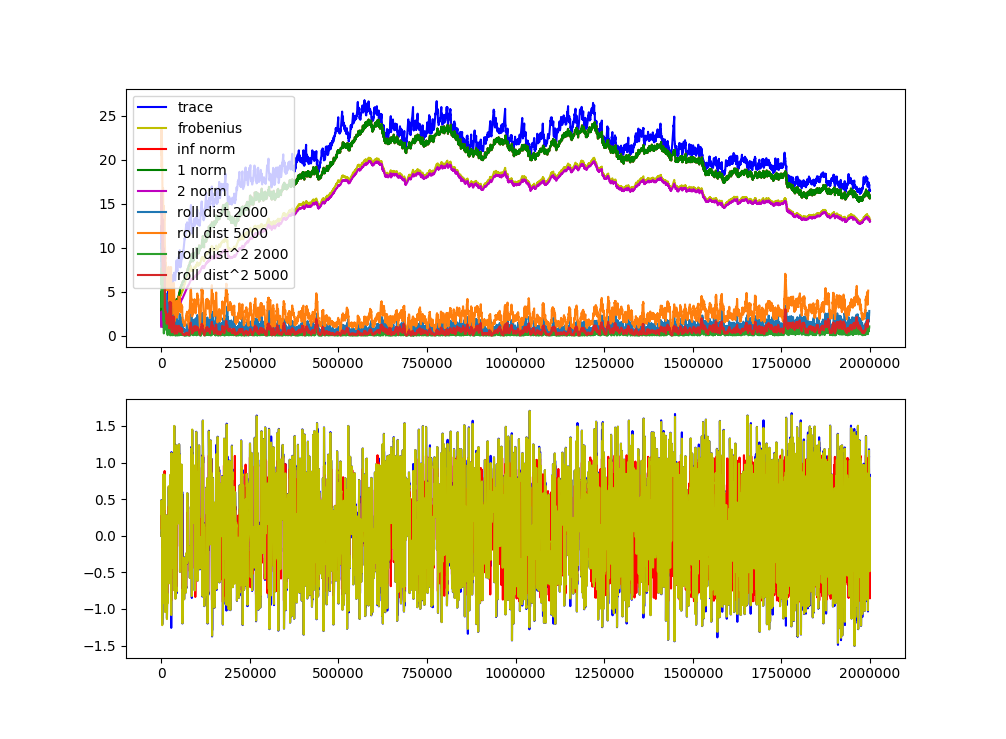

In [13]:
ax1 = plt.subplot(2, 1, 1)

ax1.plot(nor0, 'b', label="trace")
ax1.plot(nor1, 'y', label="frobenius")
ax1.plot(nor2, 'r', label="inf norm")
ax1.plot(nor3, 'g', label="1 norm")
ax1.plot(nor4, 'm', label="2 norm")

ax1.plot(0.1*np.sum(rolling_window(np.abs(np.array(y)-np.array(y_e)), 2000), -1), label="roll dist 2000")
ax1.plot(0.1*np.sum(rolling_window(np.abs(np.array(y)-np.array(y_e)), 5000), -1), label="roll dist 5000")
ax1.plot(1*np.sum(rolling_window(np.power(np.array(y)-np.array(y_e),2), 2000), -1), label="roll dist^2 2000")
ax1.plot(1*np.sum(rolling_window(np.power(np.array(y)-np.array(y_e),2), 5000), -1), label="roll dist^2 5000")

ax1.legend()
#  H-inf Norm in mov-window
#  Entropy in mov-window
#  Highpass

ax2 = plt.subplot(2, 1, 2, sharex=ax1)

plt.plot(y, 'b', label="real y")
plt.plot(u, 'r', label="setp u")
plt.plot(y_e, 'y-', label="esti y")

plt.show()

In [14]:
ss = con.ss(A_k, b_k.T, c_k, d_k)

#print A_k[:,:,0,0]
#print A_k.squeeze()
#print b_k
#print c_k
#print d_k

#print poles[-1]
print ss

A = [[ -2.10642025   3.91583318   0.        ]
 [ -3.91583318  -2.10642025   0.        ]
 [  0.           0.         -13.69923251]]

B = [[-3.24042541]
 [ 1.57507341]
 [-3.51547159]]

C = [[0.01473728 1.74086208 1.77853009]]

D = [[0.04073462]]



In [15]:
print con.dcgain(ss2)
print ss2.pole()
print ss2.zero()
print con.dcgain(ss)
print ss.pole()
print ss.zero()

1.0
[-2.+4.j -2.-4.j]
[-6.]
0.9932719021510318
[ -2.10642025+3.91583318j  -2.10642025-3.91583318j
 -13.69923251+0.        j]
[38.02383742 36.21006187 -4.79665777]


<IPython.core.display.Javascript object>


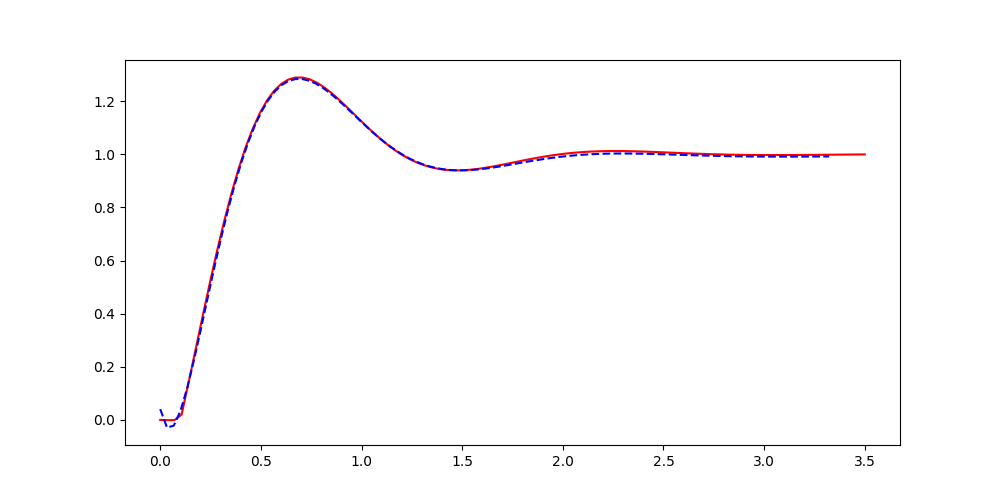

In [16]:
yout3, T3 = con.step_response(ss3)
plt.plot(yout3, T3, 'r')
#plt.show()

yout4, T4 = con.step_response(ss)
plt.plot(yout4, T4, 'b--')

plt.show()